In [1]:
from vpython import*
import math
import matplotlib.pyplot as plt
import numpy as np

<IPython.core.display.Javascript object>

In [2]:
# CONSTANTS
N = 3
k = 1
m = 1
t = 0
dt = 0.02*(2*pi*sqrt(m/k))
spacing = 1
atom_radius = 0.4*spacing

time = []
total_E = []
KE = []
PE = []

# CLASS FOR CRYSTAL LATTICE
class Crystal:
    
    def __init__(self, momentumRange ):
        self.atoms = []
        self.springs = []
        
        for z in range(-1,N+1,1):
            for y in range(-1,N+1,1):
                for x in range(-1,N+1,1):
                    atom = sphere()
                    atom.pos = vector(x,y,z)*spacing
                    atom.radius = atom_radius
                    atom.color = vector(0,0.58,0.69)
                    
                    # Give random initial momentum to each atom
                    if (0 <= x < N and 0 <= y < N and 0 <= z < N):
                        atom.momentum = vec.random()*momentumRange
                    else:
                        atom.visible = False
                        atom.momentum = vector(0,0,0)

                    atom.index = len(self.atoms)
                    self.atoms.append(atom)

        for atom in self.atoms:
            if atom.visible:
                if atom.pos.x == 0:
                    self.make_spring(self.atoms[atom.index-1], atom, False)
                    self.make_spring(atom, self.atoms[atom.index+1], True)
                elif atom.pos.x == N-1:
                    self.make_spring(atom, self.atoms[atom.index+1], False)
                else:
                    self.make_spring(atom, self.atoms[atom.index+1], True)

                if atom.pos.y == 0:
                    self.make_spring(self.atoms[atom.index-(N+2)], atom, False)
                    self.make_spring(atom, self.atoms[atom.index+(N+2)], True)
                elif atom.pos.y == N-1:
                    self.make_spring(atom, self.atoms[atom.index+(N+2)], False)
                else:
                    self.make_spring(atom, self.atoms[atom.index+(N+2)], True)
                    
                if atom.pos.z == 0:
                    self.make_spring(self.atoms[atom.index-(N+2)**2], atom, False)
                    self.make_spring(atom, self.atoms[atom.index+(N+2)**2], True)
                elif atom.pos.z == N-1:
                    self.make_spring(atom, self.atoms[atom.index+(N+2)**2], False)
                else:
                    self.make_spring(atom, self.atoms[atom.index+(N+2)**2], True)
                    
    # create a spring in between each adjacent atom
    # parameter update used in spring force to check if the spring is relevant for calculation 
    def make_spring(self, start, end, update):
            spring = helix()
            spring.update = update
            spring.pos = start.pos
            spring.axis = end.pos-start.pos
            spring.start = start
            spring.end = end
            spring.visible = False
            self.springs.append(spring)

# Undamped Spring

## Forward Euler

In [36]:
scene=canvas()
scene.center = vector(1,1,1)*0.5*(N-1)
t = 0
PE.clear()
KE.clear()
total_E.clear()
time.clear()

# Update position of each atom & calculate KE
def update_atom_pos_forward(atom):
    KE = 0
    if atom.visible:
        atom.velocity = atom.momentum/m     # p = mv
        KE = (1/2)*m*mag2(atom.velocity)    # Kinetic Energy = 1/2mv^2
        atom.pos += atom.velocity*dt

    return KE

# calculate PE in each spring & update each atom's momentum
def spring_force_forward(spring):
    PE = 0
    # Spring's stretched distance
    spring.axis = spring.end.pos - spring.start.pos
    # Length of distance you have taken (magnitude)
    L = mag(spring.axis)
    Fdt = spring.axis.norm() * (k*dt * (1-spacing/L))  # change in force
    
    if spring.start.visible:
        spring.start.momentum = spring.start.momentum + Fdt
    if spring.end.visible:
        spring.end.momentum = spring.end.momentum - Fdt
    
    # if spring exists & relevant to calculation
    if spring.update:
        # PE = 1/2 * k * x^2 where x=spring's stretched distance
        PE = (1/2)*k*mag2(spring.axis)
    # return PE of spring    
    return PE
                     
lattice = Crystal(sqrt(k/m)*0.1*spacing)

# SIMULATION
# calculate sum of the PE and KE of every atom and spring
while t < 100:
    rate(100)
    pe = 0
    ke = 0
    # Take account of KE from all atoms
    for atom in lattice.atoms:
        ke += update_atom_pos_forward(atom)
    # Take account of PE from all springs
    for spring in lattice.springs:
        pe += spring_force_forward(spring)
    
    t += dt
    PE.append(pe)
    KE.append(ke)
    total_E.append(pe + ke)
    time.append(t)

<IPython.core.display.Javascript object>

#### Kinetic Energy of Forward Integration

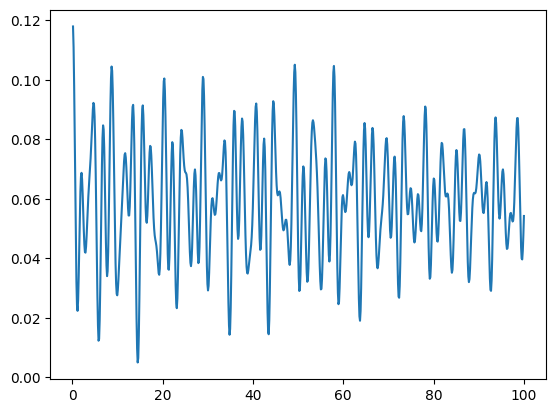

In [37]:
plt.plot(time, KE, label="Kinetic Energy")
plt.show()

#### Potential Energy of Foward Integration

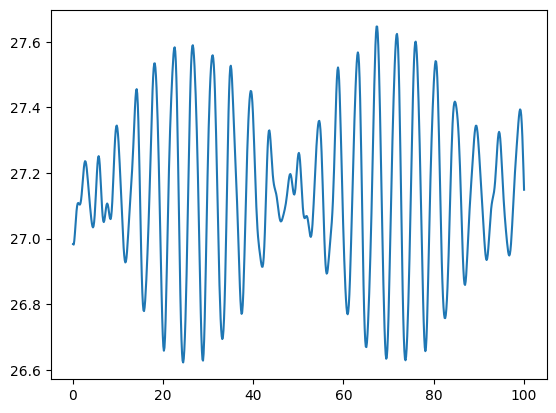

In [38]:
plt.plot(time, PE, label="Potential Energy")
plt.show()

#### Total Energy of Forward Integration

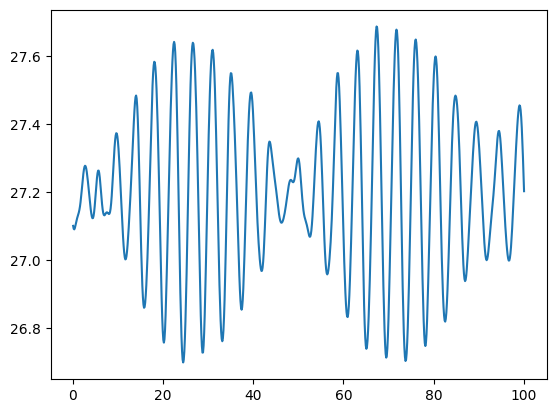

In [39]:
plt.plot(time, total_E, label="Total Energy")
plt.show()

#### Total Energy & PE

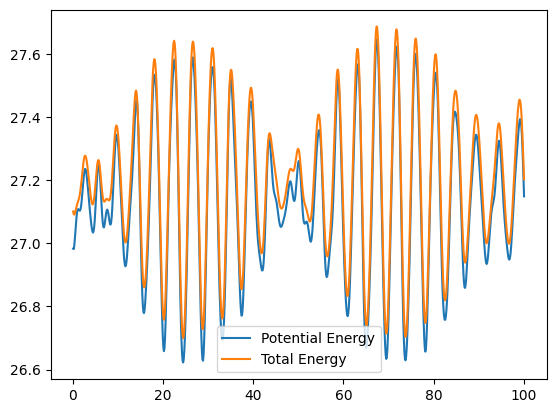

In [40]:
plt.plot(time, PE, label="Potential Energy")
plt.plot(time, total_E, label="Total Energy")
plt.legend()
plt.show()

Since Total Energy = PE + KE, PE is supposed to be smaller than total energy as shown above.

#### Proof that KE + PE = Total Energy

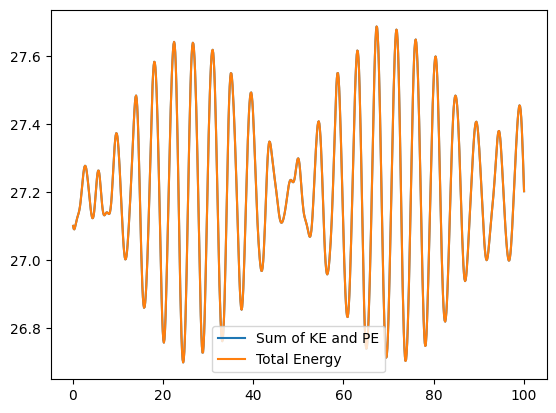

In [41]:
plt.plot(time, np.add(KE, PE), label="Sum of KE and PE")
plt.plot(time, total_E, label="Total Energy")
plt.legend()
plt.show()

***Analysis: Energy Conservation***  
As the above figures show, the energy within the system is indeed conserved. From the plot that compares the sum of KE and PE, the conservation of energy can be clearly observed.

## Backward Euler

In [42]:
scene=canvas()
scene.center = vector(1,1,1)*0.5*(N-1)

PE.clear()
KE.clear()
total_E.clear()
time.clear()
t = 0

def spring_force_backward(spring):
    PE = 0
    spring.axis = spring.end.pos - spring.start.pos
    L = mag(spring.axis)
    Fdt = spring.axis.norm() * (k*dt * (1-spacing/L))
    spring.force = Fdt
    spring.force += Fdt
    
    if spring.start.visible:
        spring.start.momentum += spring.force
        
    if spring.end.visible:
        spring.end.momentum += - spring.force
    
    if spring.update:
        PE = .5*k*mag2(spring.axis)
        
    return PE
    
def update_atom_pos_backward(atom):
    KE = 0
    if atom.visible:
        Vdt = atom.momentum/m
        KE = (1/2)*m*mag2(Vdt)
        atom.velocity = Vdt
        atom.velocity += Vdt
        atom.pos += atom.velocity*dt
        
    return KE

lattice_2 = Crystal(0.1*spacing*sqrt(k/m))

# SIMULATION
while t < 100:
    rate(100)
    pe = 0
    ke = 0
    
    # Take account of KE from all atoms
    for atom in lattice_2.atoms:
        ke += update_atom_pos_backward(atom)
    
    # Take account of PE from all springs
    for spring in lattice_2.springs:
        pe += spring_force_backward(spring)
    
    t += dt
    PE.append(pe)
    KE.append(ke)
    total_E.append(pe + ke)
    time.append(t)


<IPython.core.display.Javascript object>

#### Kinetic Energy of Backward Integration

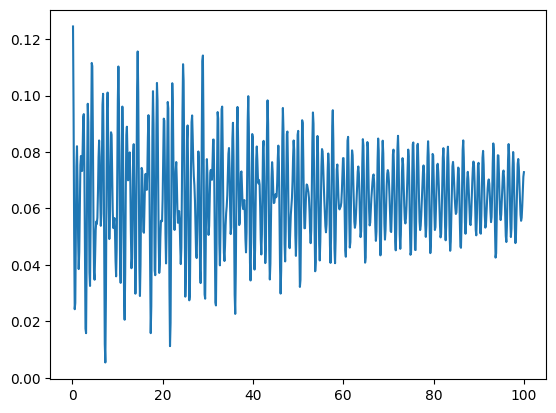

In [43]:
plt.plot(time, KE, label="Kinetic Energy")
plt.show()

#### Potential Energy of Backward Integration

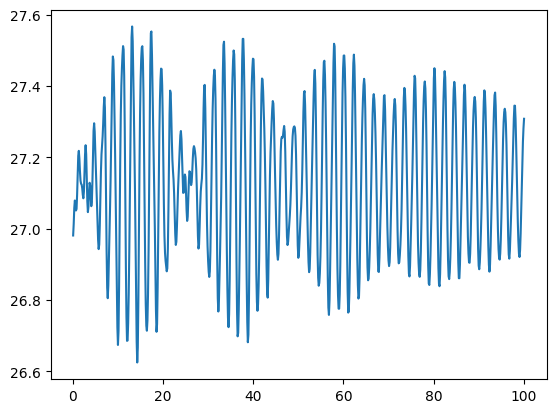

In [44]:
plt.plot(time, PE, label="Potential Energy")
plt.show()

#### Total Energy of Backward Integration

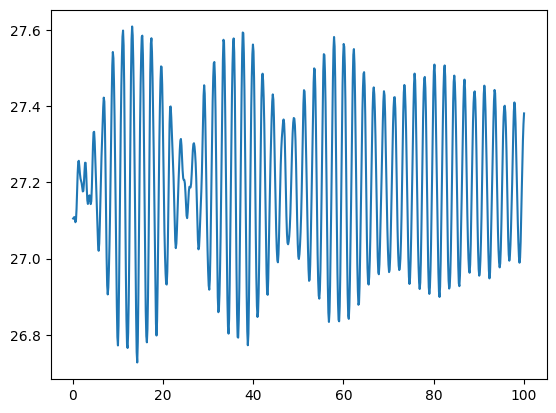

In [45]:
plt.plot(time, total_E, label="Total Energy")
plt.show()

#### PE vs Total Energy

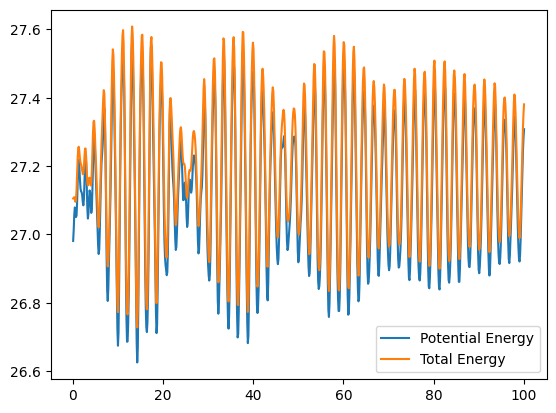

In [46]:
plt.plot(time, PE, label="Potential Energy")
plt.plot(time, total_E, label="Total Energy")
plt.legend()
plt.show()

#### Proof that KE + PE = Total Energy


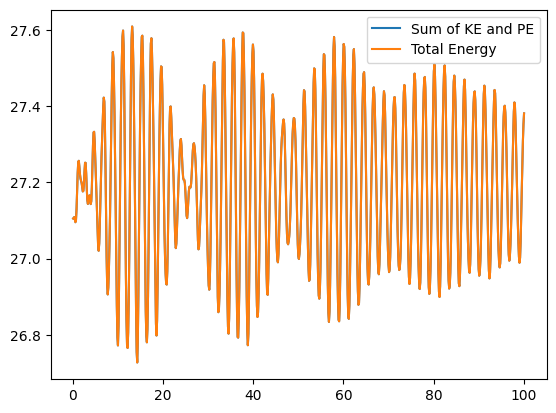

In [47]:
plt.plot(time, np.add(KE, PE), label="Sum of KE and PE")
plt.plot(time, total_E, label="Total Energy")
plt.legend()
plt.show()

***Analysis: Energy Conservation***  
As the above figures show, the energy within the system is indeed conserved. From the plot that compares the sum of KE and PE, the conservation of energy can be clearly observed.

## Trapezoid

In [20]:
scene=canvas()
scene.center = vector(1,1,1)*0.5*(N-1)

PE.clear()
KE.clear()
total_E.clear()
time.clear()
t = 0

def update_atom_pos_trapezoid(atom):
    KE = 0
    if atom.visible:
        Vdt = atom.momentum/m
        KE = .5*m*mag2(Vdt)
        atom.velocity = Vdt
        atom.velocity += Vdt
        atom.pos += (Vdt + atom.velocity)*.5*dt
        
    return KE

def spring_force_trapezoid(spring):
    PE = 0
    spring.axis = spring.end.pos - spring.start.pos
    L = mag(spring.axis)
    Fdt = spring.axis.norm() * (k * (1-spacing/L))
    spring.force = Fdt
    spring.force = (spring.force + Fdt)*.5*dt
    if spring.start.visible:
        spring.start.momentum += spring.force
    if spring.end.visible:
        spring.end.momentum += -spring.force
    if spring.update:
        PE = (1/2)*k*mag2(spring.axis)
        
    return PE

lattice_3 = Crystal(0.1*spacing*sqrt(k/m))

# SIMULATION
while t < 100:
    rate(100)
    pe = 0
    ke = 0
    # Take account of KE from all atoms
    for atom in lattice_3.atoms:
        ke += update_atom_pos_trapezoid(atom)
    
    # Take account of PE from all springs
    for spring in lattice_3.springs:
        pe += spring_force_trapezoid(spring)
    
    t += dt
    PE.append(pe)
    KE.append(ke)
    total_E.append(pe + ke)
    time.append(t)

<IPython.core.display.Javascript object>

#### Kinetic Energy of Trapezoid Integration

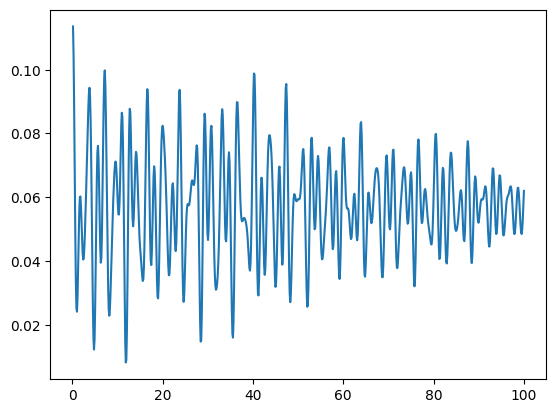

In [21]:
plt.plot(time, KE, label="Total Energy")
plt.show()

#### Potential Energy of Trapezoid Integration

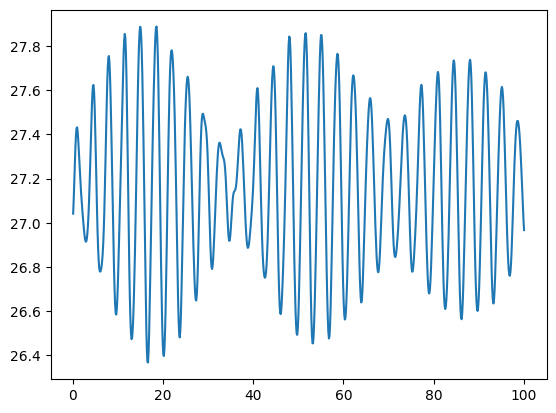

In [22]:
plt.plot(time, PE, label="Total Energy")
plt.show()

#### Total Energy of Trapezoid Integration

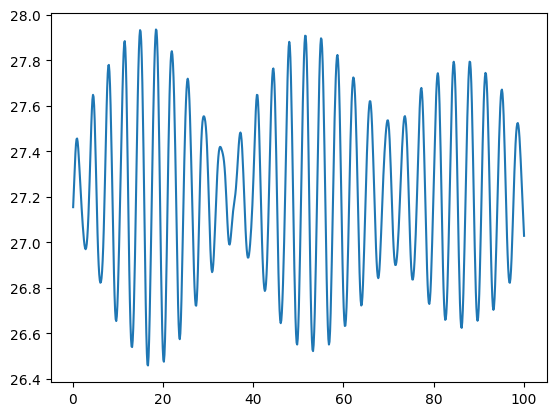

In [23]:
plt.plot(time, total_E, label="Total Energy")
plt.show()

#### PE vs Total Energy

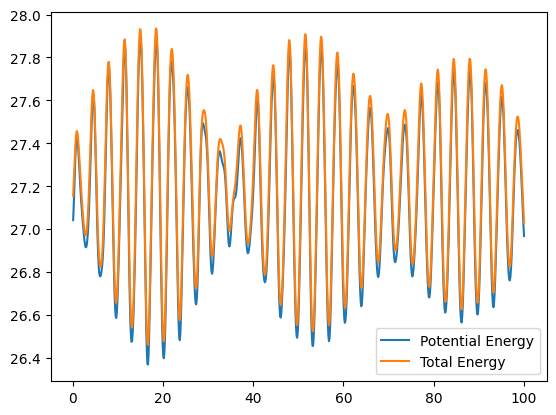

In [24]:
plt.plot(time, PE, label="Potential Energy")
plt.plot(time, total_E, label="Total Energy")
plt.legend()
plt.show()

#### Proof that KE + PE = Total Energy

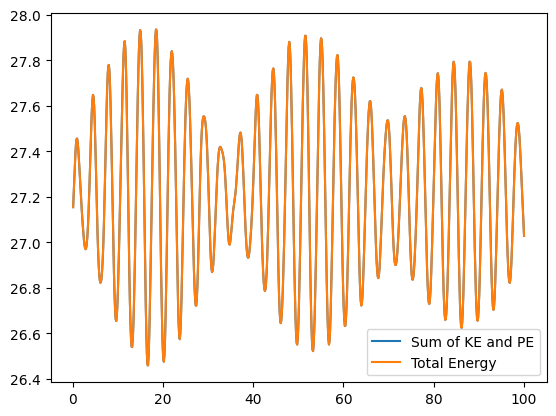

In [25]:
plt.plot(time, np.add(KE, PE), label="Sum of KE and PE")
plt.plot(time, total_E, label="Total Energy")
plt.legend()
plt.show()

***Analysis: Energy Conservation***  
As the above figures show, the energy within the system is indeed conserved. From the plot that compares the sum of KE and PE, the conservation of energy can be clearly observed.

***Analysis: Integration Methods***  
For the simulation, the forward integration, backward integration, and trapezoid integration have been used. Since random momentum was given to each atom of the crystal lattice structure from each integration, it is hard to compare them with their figures generated to show the change in energy over time. For all methods, dt of ~0.1256 has been selected. From the plots, it is difficult to find the difference between the forward euler method and the trapezoid method. However, backward euler method shows a significant increase in its frequency of oscillation. 

# Damped Spring

## Forward Euler Method

In [34]:
scene=canvas()
scene.center = vector(1,1,1)*0.5*(N-1)
t = 0
dc = 0.8   # Damp Constant
time = []
total_E = []
KE = []
PE = []

# Update position of each atom & calculate KE
def update_atom_pos_forward(atom):
    KE = 0
    if atom.visible:
        atom.velocity = atom.momentum/m     # p = mv
        KE = (1/2)*m*mag2(atom.velocity)    # Kinetic Energy = 1/2mv^2
        atom.pos += atom.velocity*dt

    return KE

# calculate PE in each spring & update each atom's momentum
def spring_force_forward(spring):
    PE = 0
    # Spring's stretched distance
    spring.axis = spring.end.pos - spring.start.pos
    # Length of distance you have taken (magnitude)
    L = mag(spring.axis)
    Fdt = spring.axis.norm() * (k*dt * (1-spacing/L)) * dc  # change in force
    
    if spring.start.visible:
        spring.start.momentum = spring.start.momentum + Fdt
    if spring.end.visible:
        spring.end.momentum = spring.end.momentum - Fdt
    
    # if spring exists & relevant to calculation
    if spring.update:
        # PE = 1/2 * k * x^2 where x=spring's stretched distance
        PE = (1/2)*k*mag2(spring.axis)
    # return PE of spring    
    return PE
                     
lattice = Crystal(sqrt(k/m)*0.1*spacing)

# SIMULATION
# calculate sum of the PE and KE of every atom and spring
while t < 200:
    rate(100)
    pe = 0
    ke = 0
    
    # Take account of KE from all atoms
    for atom in lattice.atoms:
        ke += update_atom_pos_forward(atom)
    
    # Take account of PE from all springs
    for spring in lattice.springs:
        pe += spring_force_forward(spring)
    
    t += dt
    PE.append(pe)
    KE.append(ke)
    total_E.append(pe + ke)
    time.append(t)

<IPython.core.display.Javascript object>

#### Total Energy over time

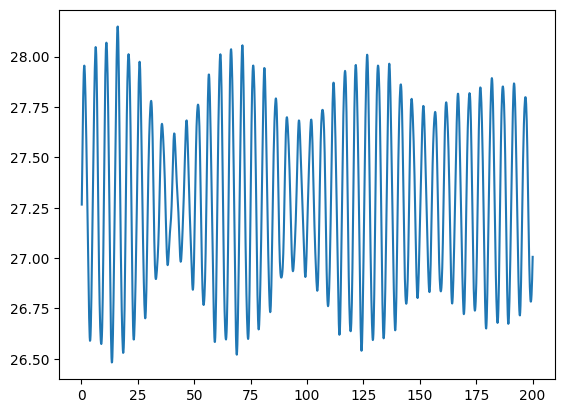

In [35]:
plt.plot(time, total_E, label="Total Energy")
plt.show()

***Analysis: Spring Damping***  
To observe the damping spring, forward euler method has been selected. Compared to the total energy plot from the undamped forward euler method, it is clearly showing a decrease in the total energy over time because the system is no longer isolated and the total energy within the system is getting affected by the spring damping.

### All References


https://urs.silvrback.com/numerical-integration  
https://www.glowscript.org/#/user/GlowScriptDemos/folder/Examples/program/AtomicSolid-VPython  
https://math.libretexts.org/Bookshelves/Differential_Equations/Numerically_Solving_Ordinary_Differential_Equations_(Brorson)/01%3A_Chapters/1.03%3A_Backward_Euler_method#:~:text=The%20backward%20Euler%20method%20is,%2B1)%3Dyn.  
https://web.mit.edu/10.001/Web/Course_Notes/Differential_Equations_Notes/node3.html  